In [1]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import re
import pickle
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

[nltk_data] Error loading wordnet: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>


Importing Dataset

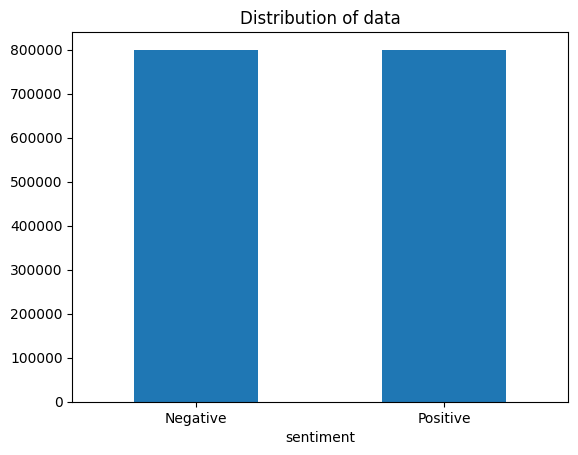

In [4]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('./training.1600000.processed.noemoticon.csv',encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

dataset = dataset[['sentiment','text']]
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

Pre-Processing

In [5]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [6]:
def preprocess(textdata):
    processedText = []
    
    wordLemm = WordNetLemmatizer()
    
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        tweet = re.sub(urlPattern,' URL',tweet)
        
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        
        tweet = re.sub(userPattern,' USER', tweet)        
        
        tweet = re.sub(alphaPattern, " ", tweet)
        
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        tweetwords = ''
        for word in tweet.split():
            if len(word)>1:
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
        processedText.append(tweetwords)
        
    return processedText

In [7]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 63 seconds


Making WORD-CLOUD for both positive and negative tweets

For Positive Tweets:


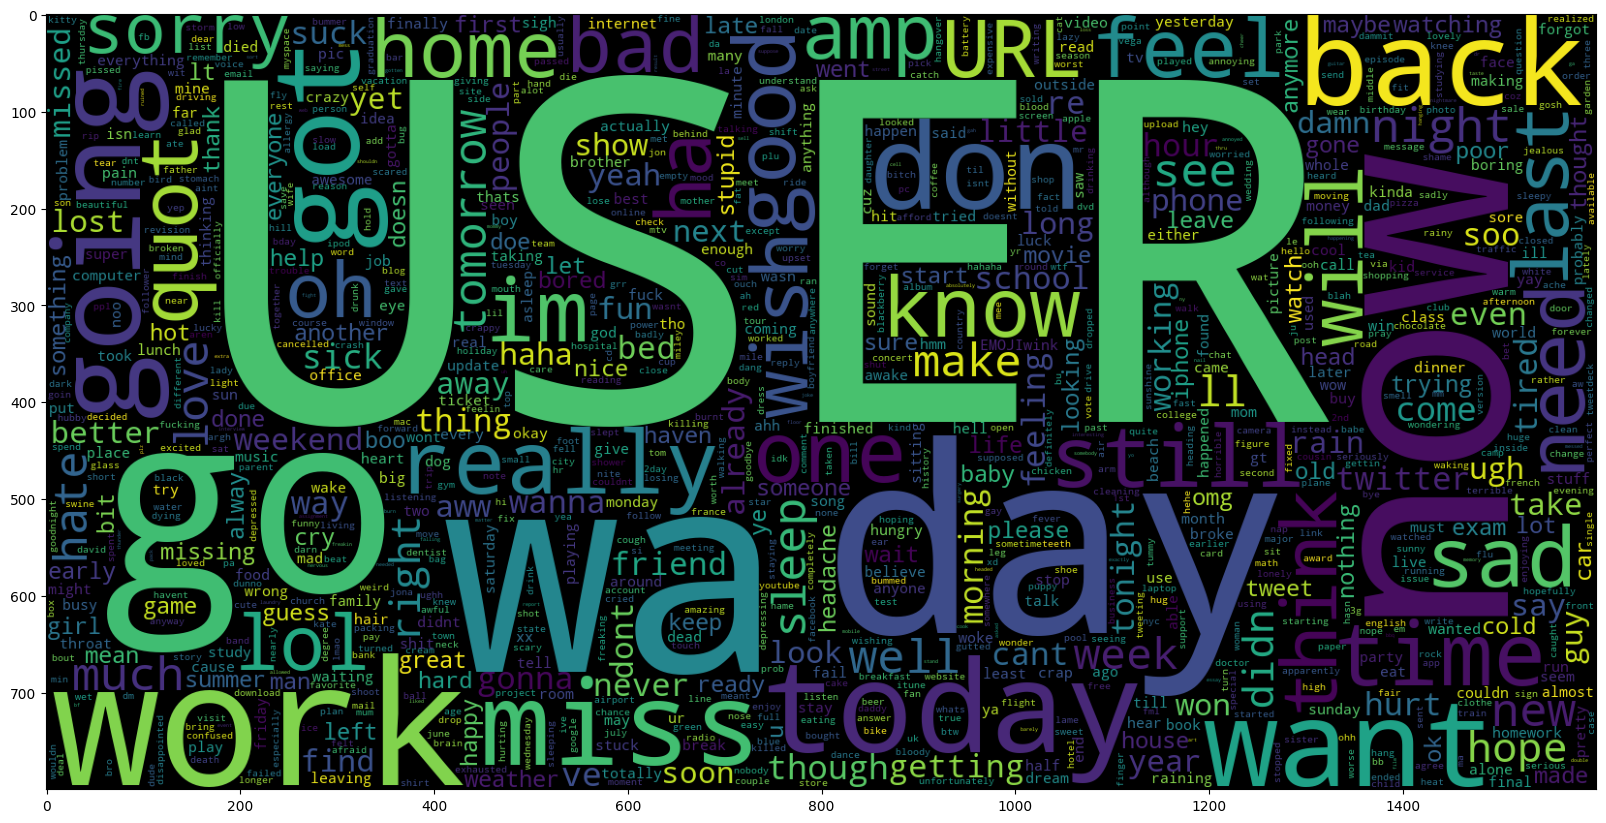

In [8]:
print("For Positive Tweets:")
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

For Negative Tweets:


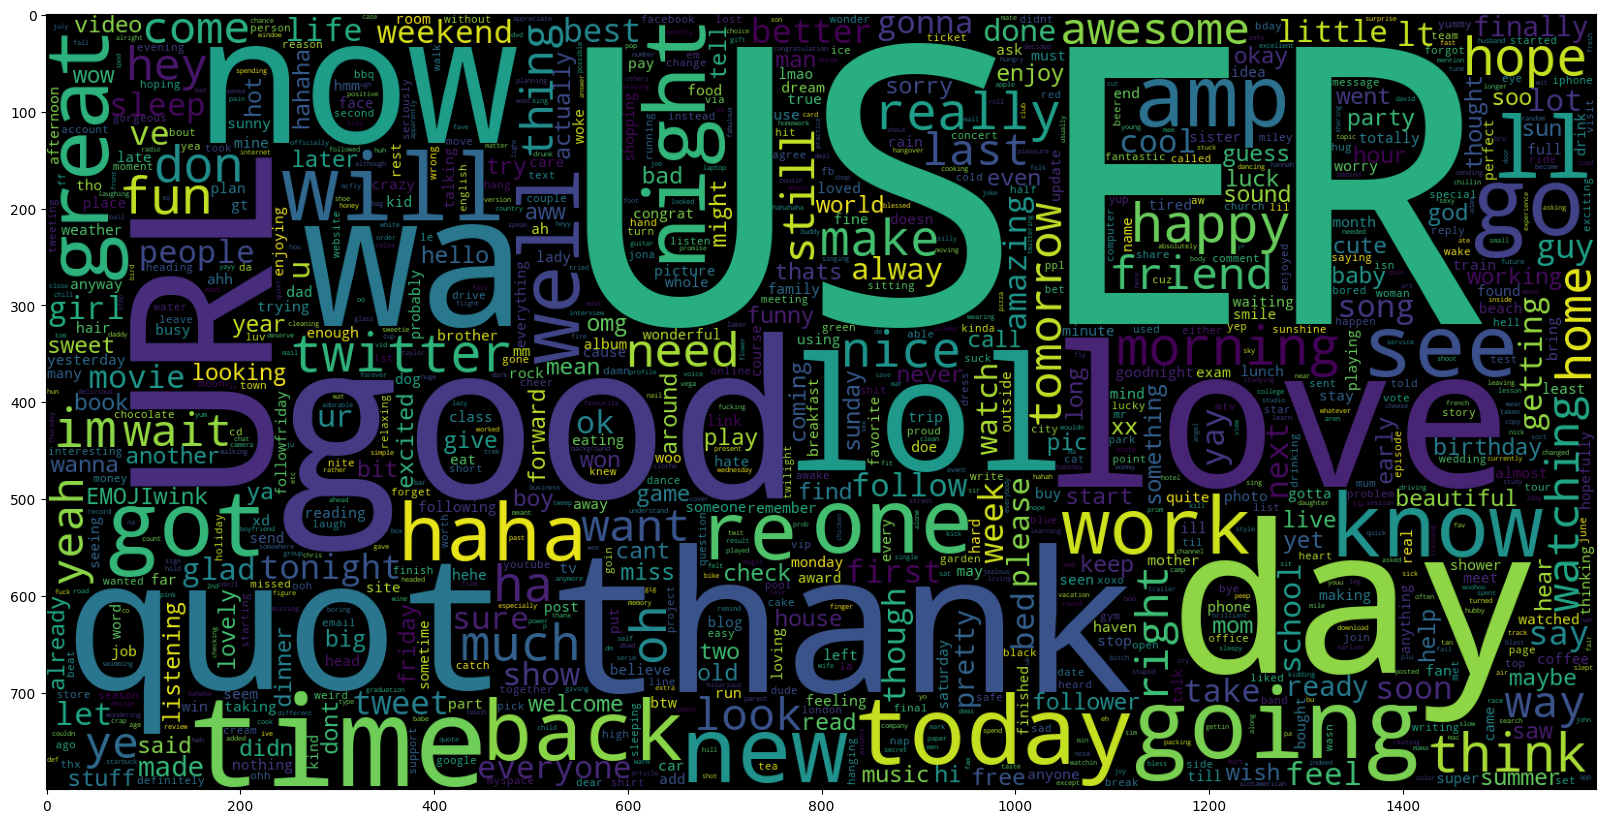

In [9]:
print("For Negative Tweets:")
data_neg = processedtext[800000:]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Splitting Test-Train Data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,test_size = 0.05, random_state = 0)

In [11]:
import time
t = time.time()
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))
print(f'Time Taken: {round(time.time()-t)} seconds')

X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

No. of feature_words:  500000
Time Taken: 38 seconds


Model Evaluation

In [12]:
def model_Evaluate(model):
    
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))
    
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**BernoulliNB Model**

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



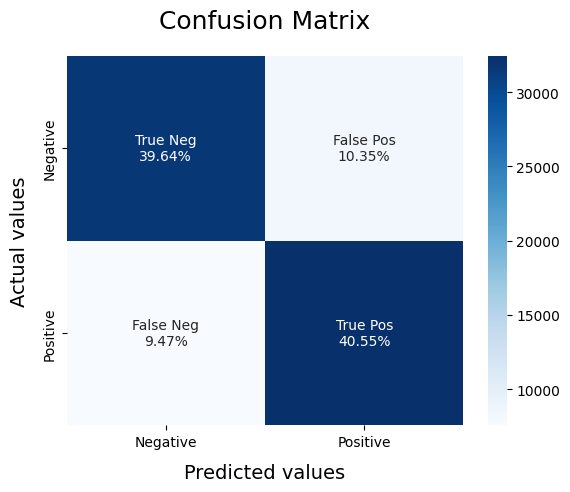

In [13]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

**LinearSCV Model**

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



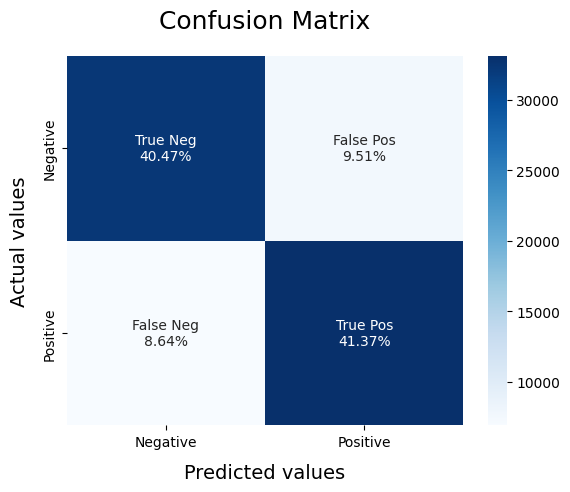

In [14]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

**Logistic Regression Model**

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



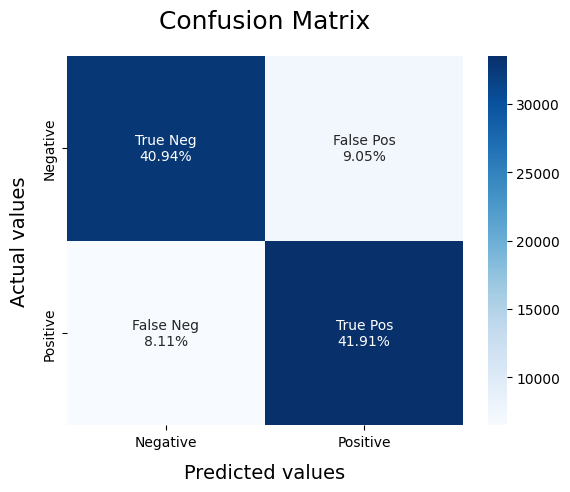

In [15]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

Saving

In [16]:
file = open('./vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('./Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('./Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

Using the model

In [17]:
def load_models():
    
    file = open('./vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    
    file = open('./Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

while True:
    inp = str(input("The Statement:"))

    df = predict(vectoriser, LRmodel, [inp])
    print(f"The Statement is {df.values[0][1]}")
    
    if str(input("Do u want to exit(y/n):")) == "y":
        break
    

The Statement:I want to live like that
The Statement is Negative
Do u want to exit(y/n):n
The Statement:I am confident on my success
The Statement is Positive
Do u want to exit(y/n):n
The Statement:I want to die
The Statement is Negative
Do u want to exit(y/n):y
